In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random as rnd

In [2]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
PATH = '../'
BUFFER_SIZE = 2000
BATCH_SIZE = 128
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [4]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.reduce_max(image, axis=-1, keepdims=True)
    return image

In [46]:
def create_true_samples(*datasets):
    merged_dataset = tf.data.Dataset.zip(datasets)
    
    def select_2_imgs(*imgs):
        indices = tf.random.shuffle(tf.range(len(imgs)))[:2]
        selected_imgs = tf.gather(imgs, indices)
        return selected_imgs[0], selected_imgs[1]

    final_dataset = merged_dataset.map(select_2_imgs)

    return final_dataset

In [101]:
train_dataset_1 = tf.data.Dataset.list_files(str(PATH + 'resources/data/class_test/Carattere-Regular/*.jpg'), shuffle=False).map(load,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_2 = tf.data.Dataset.list_files(str(PATH + 'resources/data/class_test/Sacramento-Regular/*.jpg'), shuffle=False).map(load,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_3 = tf.data.Dataset.list_files(str(PATH + 'resources/data/class_test/Sevillana-Regular/*.jpg'), shuffle=False).map(load,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_4 = tf.data.Dataset.list_files(str(PATH + 'resources/data/class_test/SingleDay-Regular/*.jpg'), shuffle=False).map(load,num_parallel_calls=tf.data.AUTOTUNE)

train_dataset_true = create_true_samples(train_dataset_1, train_dataset_2, train_dataset_3, train_dataset_4)
train_dataset_false = tf.data.Dataset.zip((train_dataset_1.skip(half_size), train_dataset_2.skip(half_size).shuffle(buffer_size=half_size)))

train_dataset_true = train_dataset_true.map(lambda x1,x2:((x1,x2),1.0))
train_dataset_false = train_dataset_false.map(lambda x1,x2:((x1,x2),0.0))



train_dataset = train_dataset_true.concatenate(train_dataset_false).shuffle(BUFFER_SIZE)

train_size = int(0.9 * train_dataset.cardinality().numpy())
test_dataset = train_dataset.skip(train_size)
train_dataset = train_dataset.take(train_size)

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


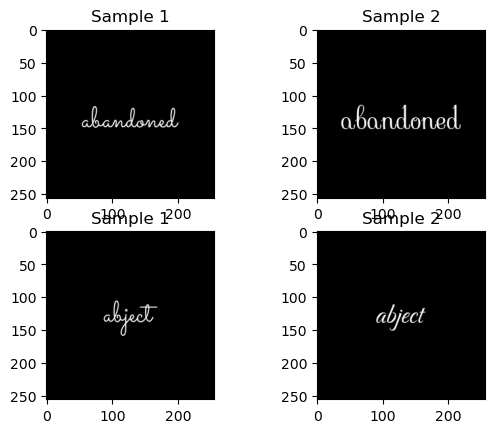

In [54]:
sample_1 = train_dataset_true.take(1).get_single_element()
sample_2 = train_dataset_true.skip(5).take(1).get_single_element()
plt.subplot(221)
plt.title('Sample 1')
plt.imshow(sample_1[0] * 0.5 + 0.5, cmap='gray')

plt.subplot(222)
plt.title('Sample 2')
plt.imshow(sample_1[1] * 0.5 + 0.5, cmap='gray')

plt.subplot(223)
plt.title('Sample 1')
plt.imshow(sample_2[0] * 0.5 + 0.5, cmap='gray')

plt.subplot(224)
plt.title('Sample 2')
plt.imshow(sample_2[1] * 0.5 + 0.5, cmap='gray')

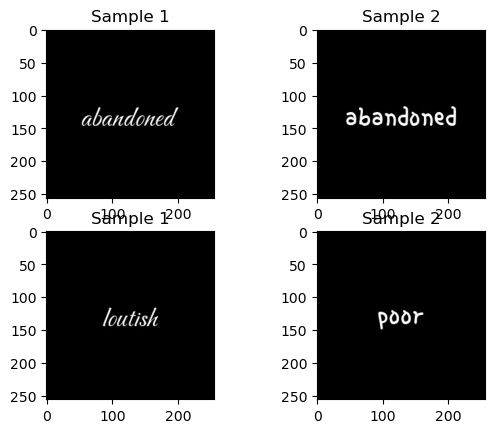

In [102]:
sample_1 = next(iter(train_dataset_true))
sample_2 = next(iter(train_dataset_false))

plt.subplot(221)
plt.title('Sample 1')
plt.imshow(sample_1[0][0] * 0.5 + 0.5, cmap='gray')

plt.subplot(222)
plt.title('Sample 2')
plt.imshow(sample_1[0][1] * 0.5 + 0.5, cmap='gray')

plt.subplot(223)
plt.title('Sample 1')
plt.imshow(sample_2[0][0] * 0.5 + 0.5, cmap='gray')

plt.subplot(224)
plt.title('Sample 2')
plt.imshow(sample_2[0][1] * 0.5 + 0.5, cmap='gray')

In [103]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self):
    super(InstanceNormalization, self).__init__()
    self.epsilon =1e-5

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

In [104]:
def downsample(filters, size, apply_norm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [105]:
def Discriminator():
    """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).
  
    Args:
      norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
      target: Bool, indicating whether target image is an input or not.
  
    Returns:
      Discriminator model
    """

    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1], name='input_image')
    x = inp

    
    tar = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1, kernel_initializer=initializer,
        use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    norm1 = InstanceNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last_conv = tf.keras.layers.Conv2D(
        1, 4, strides=1,
        kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    fl = tf.keras.layers.Flatten()(last_conv)
    
    last = tf.keras.layers.Dense(1)(fl)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
   

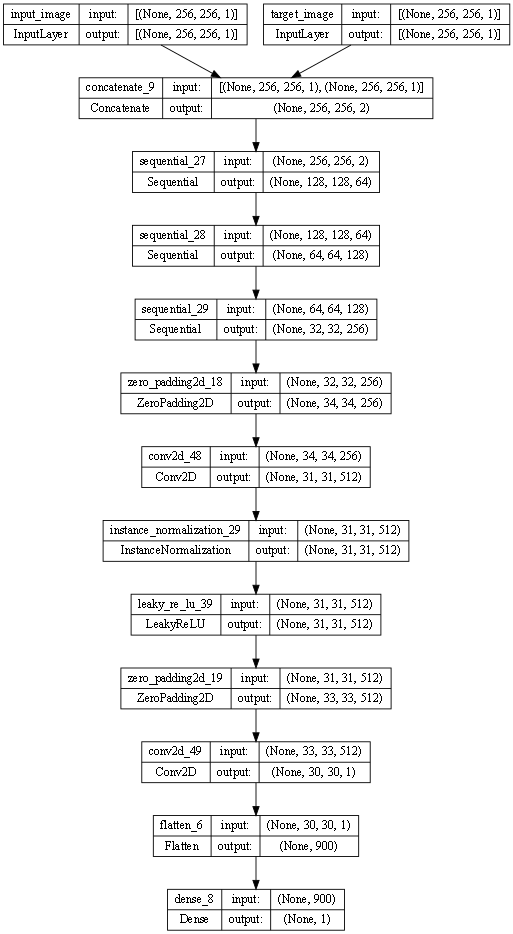

In [106]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [107]:
discriminator.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_9 (Concatenate)    (None, 256, 256, 2)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

In [108]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [109]:
discriminator.compile(loss=loss_object, optimizer='adam', metrics=['accuracy',tf.keras.metrics.Recall()])

In [110]:
history = discriminator.fit(train_dataset,epochs=20,validation_data=test_dataset)

Epoch 1/20
15/15 [==============================] - 14s 724ms/step - loss: 1.5977 - accuracy: 0.5289 - recall_3: 0.3670 - val_loss: 0.6293 - val_accuracy: 0.6219 - val_recall_3: 0.4490
Epoch 2/20
15/15 [==============================] - 13s 745ms/step - loss: 0.6237 - accuracy: 0.6500 - recall_3: 0.4590 - val_loss: 0.6092 - val_accuracy: 0.6368 - val_recall_3: 0.2979
Epoch 3/20
15/15 [==============================] - 13s 743ms/step - loss: 0.5700 - accuracy: 0.6717 - recall_3: 0.4587 - val_loss: 0.5202 - val_accuracy: 0.7214 - val_recall_3: 0.6190
Epoch 4/20
15/15 [==============================] - 13s 745ms/step - loss: 0.5274 - accuracy: 0.7194 - recall_3: 0.5457 - val_loss: 0.5396 - val_accuracy: 0.7214 - val_recall_3: 0.6067
Epoch 5/20
15/15 [==============================] - 13s 757ms/step - loss: 0.4525 - accuracy: 0.7717 - recall_3: 0.6222 - val_loss: 0.3037 - val_accuracy: 0.8756 - val_recall_3: 0.8119
Epoch 6/20
15/15 [==============================] - 13s 754ms/step - loss: 

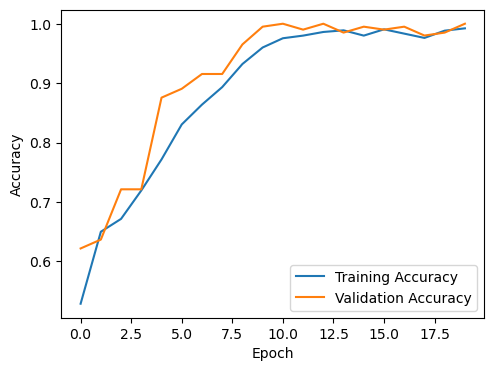

In [111]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [147]:
discriminator.save('../models/semantic-word-discriminator-Car-Sing-256x256.keras')

In [143]:
tf.shape([inp[tf.newaxis, ...],tar[tf.newaxis, ...]])

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([  2,   1, 256, 256,   1])>

In [141]:
discriminator.input

[<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'input_image')>,
 <KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'target_image')>]

In [145]:
inp = sample_2[0][0]
tar = sample_2[0][1]
s = [inp[tf.newaxis, ...], tar]

In [146]:
discriminator([inp[tf.newaxis, ...],tar[tf.newaxis, ...]])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-8.036078]], dtype=float32)>